<a href="https://colab.research.google.com/github/prudhvi6e/playing-cards-detection-yolov5/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to Train YOLOv5 on Custom Objects**

This tutorial is based on the YOLOv5 repository by Ultralytics. This notebook shows training on your own custom objects. Many thanks to Ultralytics for putting this repository together - I hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

**Accompanying Blog Post**

I recommend that you follow along in this notebook while reading the blog post on how to train YOLOv5, concurrently.

**Steps Covered in this Tutorial**

In this tutorial, I will walk through the steps required to train YOLOv5 on your custom objects. I used a public dataset i.e.., playing card detection dataset, which is open source and free to use. You can also use this notebook on your own data.

*To train our detector we take the following steps:*

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference


About
Roboflow enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

Looking for a vision model available via API without hassle? Try [Roboflow](https://roboflow.com/) Train.

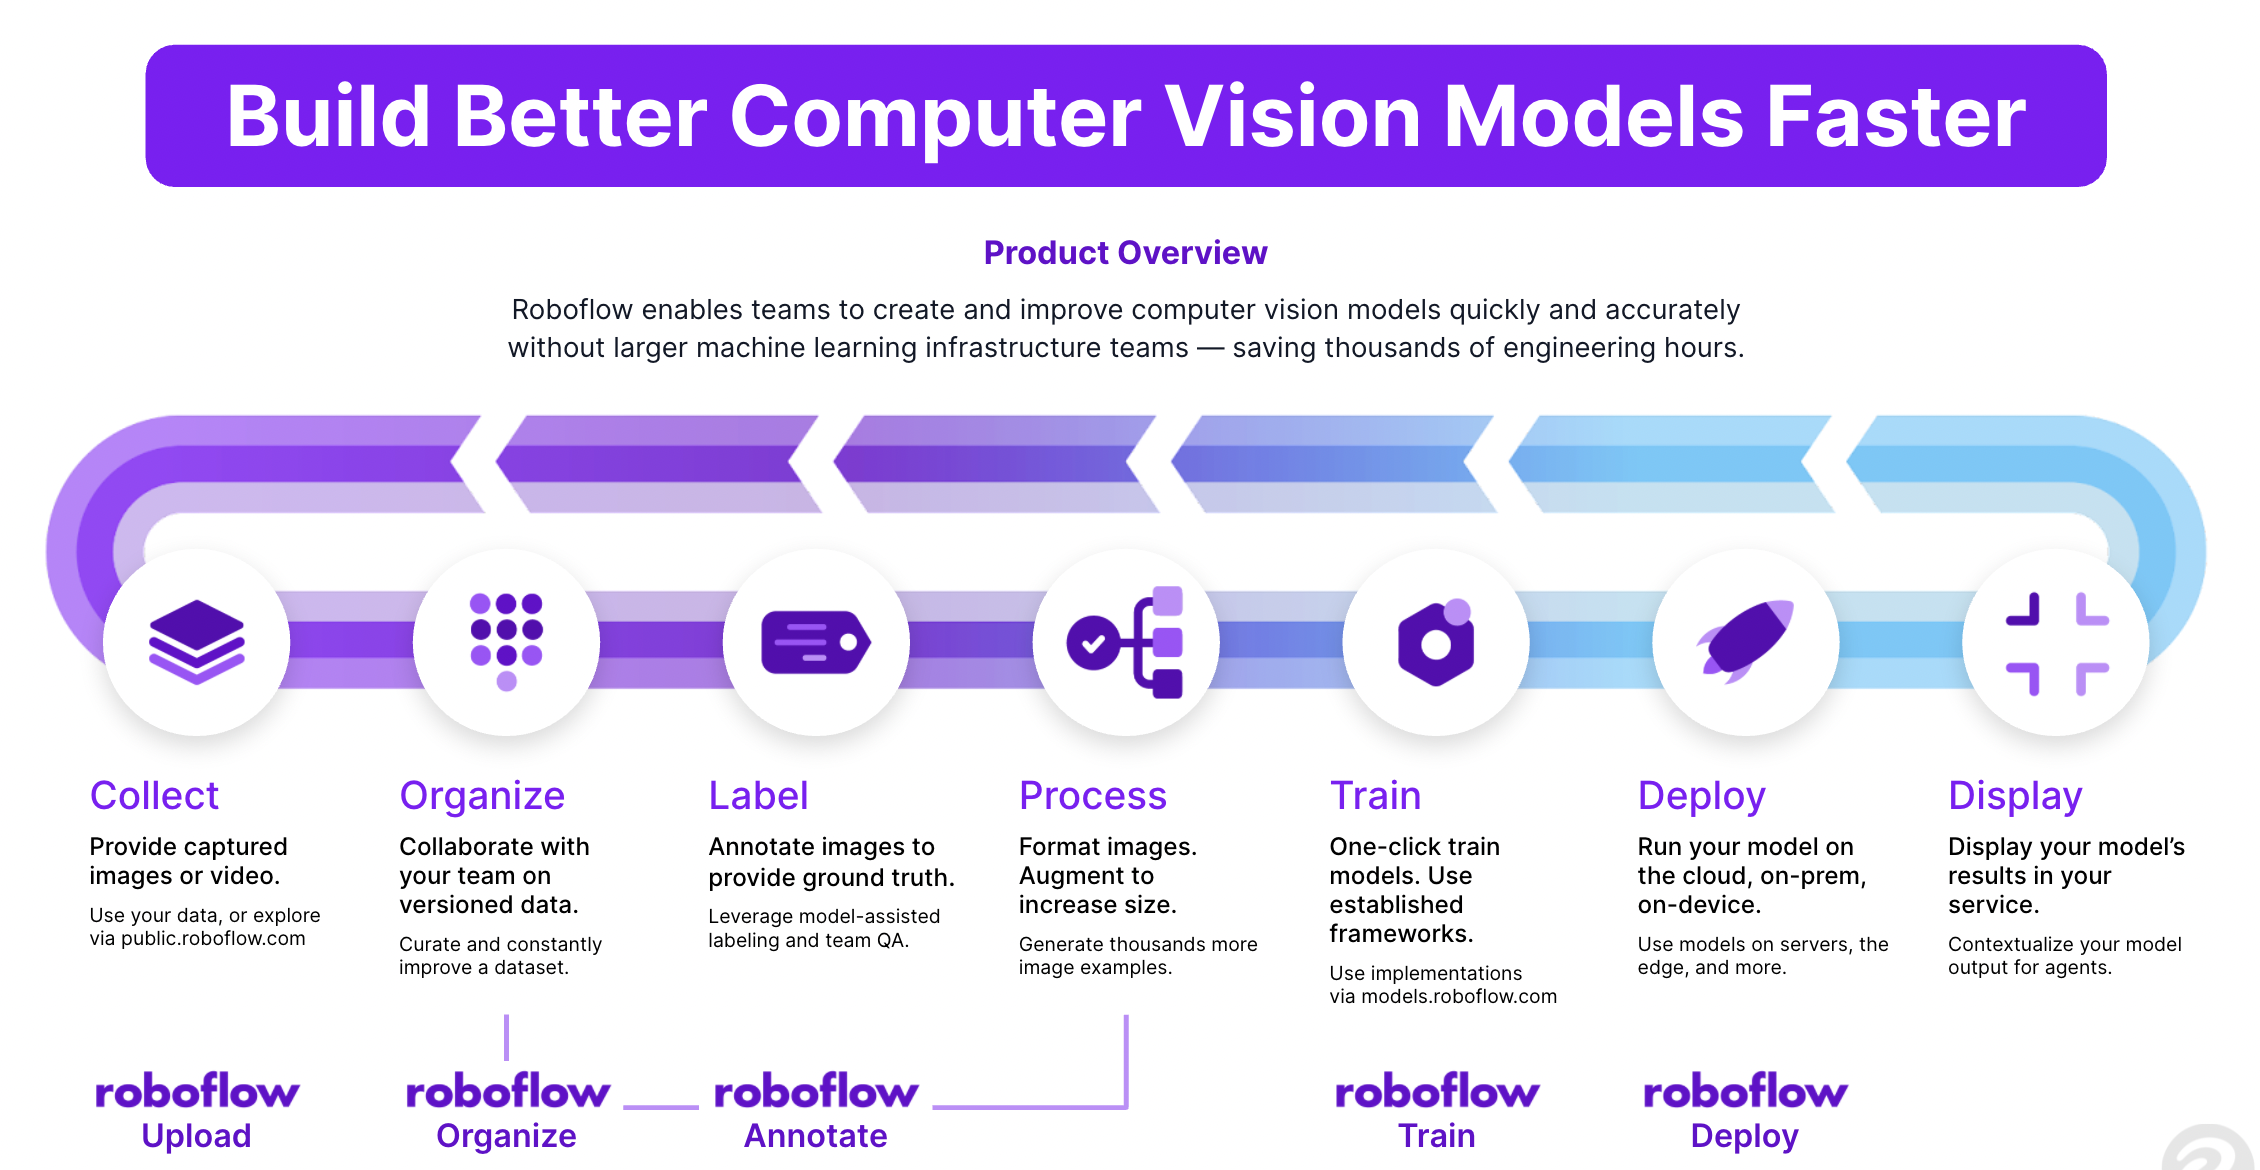


Before Installing Dependencies

(please be sure to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)

In [ ]:
# clone YOLOv5 and reset to a specific git checkpoint that has been verified working
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 68211f72c99915a15855f7b99bf5d93f5631330f

In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
%cd '/content/yolov5'

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
from roboflow import Roboflow
rf = Roboflow(api_key="rs8W93XGVcly6z4S78Ar")
rf.workspace().project("playing-cards-ow27d").version(1).download("yolov5")

In [ ]:
%cd /content/yolov5/Playing-Cards-1/
%cat data.yaml

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/yolov5/Playing-Cards-1/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

**Train Custom YOLOv5 Detector**

Next, we'll fire off training!

*Here, we are able to pass a number of arguments:*

* img: define input image size
* batch: determine batch size
* epochs: define the number of training epochs. (Note: often, 3000+ are common here!)
* data: set the path to our yaml file
* cfg: specify our model configuration
* weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
* name: result names
* nosave: only save the final checkpoint
* cache: cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 45 --data '/content/yolov5/Playing-Cards-1/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  


If you encounter this runtime error while executing


```
 22          [-1, 10]  1         0  models.common.Concat                    [1]                           
 23                -1  1   1248768  models.common.BottleneckCSP             [512, 512, 1, False]          
 24      [17, 20, 23]  1    229245  models.yolo.Detect                      [80, [[10, 13, 16, 30, 33, 23], [30, 61, 62, 45, 59, 119], [116, 90, 156, 198, 373, 326]], [128, 256, 512]]
Traceback (most recent call last):
  File "train.py", line 492, in <module>
    train(hyp, opt, device, tb_writer, wandb)
  File "train.py", line 83, in train
    model = Model(opt.cfg or ckpt['model'].yaml, ch=3, nc=nc).to(device)  # create
  File "/usr/src/app/models/yolo.py", line 95, in __init__
    self._initialize_biases()  # only run once
  File "/usr/src/app/models/yolo.py", line 150, in _initialize_biases
    b[:, 4] += math.log(8 / (640 / s) ** 2)  # obj (8 objects per 640 image)
RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
```

Just replace these two lines in yolo.py file (line no 150)

```
b.data[:, 4] += math.log(8 / (640 / s) ** 2)  # obj (8 objects per 640 image)

b.data[:, 5:] += math.log(0.6 / (m.nc - 0.99)) if cf is None else torch.log(cf / cf.sum())  # cls
```

Now you are good to go and train your model...

**Evaluate Custom YOLOv5 Detector Performance**

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results. (If given no name, it defaults to results.txt.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results().

In [ ]:
import tensorflow as tf
import datetime
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

**Curious? Visualize Our Training Data with Labels**


After training starts, view train*.jpg images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in YOLOv4.

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

**Run Inference With Trained Weights**

Run inference with a pretrained checkpoint on contents of test/images folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

In [ ]:
%ls /content/yolov5/weights/yolov5Cards

# !cp '/content/drive/MyDrive/Trained/best.pt' "/content/"

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
import glob 
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/test/images --save-txt --save

In [ ]:
filename = '/content/drive/MyDrive/Cards Dataset/Large_Dataset-26000/obj.names'
classes = []
with open(filename,'r') as fh:
    for line in fh:
        classes.append(line.split('\n')[0])

names = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '6', '7', '8', '9']

names = [int(name) for name in names]

In [ ]:
predictions = glob.glob('/content/yolov5/runs/detect/exp/labels/*.txt')
from google.colab.patches import cv2_imshow
import cv2
import tqdm

def bbox(x, y, width, height):
    x = x * 416
    y = y * 416
    width = width * 416
    height = height * 416
    x1 = int(x - (width/2))
    y1 = int(y - (height/2))
    x2 = int(x + (width/2))
    y2 = int(y + (height/2))

    return x1, y1, x2, y2
    
for prediction_file in tqdm.tqdm(predictions):

    file_number = prediction_file.split('/')[-1].split('.')[0]

    img = f'/content/test/images/{file_number}.jpg'
    label = f'/content/yolov5/runs/detect/exp/labels/{file_number}.txt'
    image = cv2.imread(img)

    with open(label, 'r') as f:
        for line in f:
            values = line.split(' ')
            pred = classes[int(values[0])]
            x, y, w, h = float(values[1]), float(values[2]), float(values[3]), float(values[4])
            conf = float(values[5].split('\n')[0])
            x1,y1,x2,y2 = bbox(x, y, w, h)
            cv2.rectangle(image, (x1,y1), (x2,y2), (0,0,0), 2)
            text = f'{pred}'
            cv2.rectangle(image, (x1-1,y1-15), (x1+35,y1), (255,255,255), -1)
            cv2.putText(image, text, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)

    # display(Image(filename=img))
    n = f'/content/testing_results/{file_number}.jpg'
    cv2.imwrite(n, image)

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display
from random import randint

test_images = glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:2]

for imageName in test_images: #assuming JPG

    print(classes[names.index(4)], classes[names.index(31)])
    display(Image(filename=imageName))
    #print("\n")

In [ ]:
!zip -r /content/testing_images.zip /content/testing_results